In [8]:
import time, sys

import numpy as np
import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')

from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [9]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_MSE(oper_char):
    specific_method = "MLE"  # Replace with the name of your method
    
    # Create a modified DataFrame
    df_modified = oper_char.copy()
    
    # For the specific method, keep "tau" values separate
    # For other methods, set "tau" to a single category, e.g., "All"
    df_modified['prop'] = df_modified.apply(
        lambda row: row['prop'] if row['method'] == specific_method else 'Naive/DS', axis=1
    )
    
    # Plotting
    sns.boxplot(x='method', y='MSE', hue='prop', data=df_modified, showmeans=True)
    plt.xlabel("Method")
    plt.ylabel("MSE")
    plt.title("Boxplot of MSE by Method and prop")
    plt.show()


# Toy example: vary randomization scale

In [10]:
def predict(beta_hat, X_test):
    return X_test.dot(beta_hat)

def generate_test(Y_mean, noise_sd):
    n = Y_mean.shape[0]
    Y_test = Y_mean + np.random.normal(size=(n,), scale=noise_sd)
    
    return Y_test

In [5]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
#oper_char["MSE"] = []
oper_char["prop"] = []
oper_char["rho"] = []
oper_char["signal"] = []
oper_char["main signal"] = []
oper_char["target"] = []
oper_char["power"] = []

MSE_dict = {}
MSE_dict["MSE"] = []
MSE_dict["method"] = []
MSE_dict["prop"] = []

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []
target_dict["index"] = []
target_dict["pivot"] = []
target_dict["pval"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of main signal strengths 
# to be considered) has a corresponding dictionary of results
parameter_list = np.array([0.5, 0.6, 0.7, 0.8, 0.9])#np.array([0.02, 0.04, 0.06])#np.array([10, 5, 2, 1])
pval_dict = {}
for x in parameter_list:
    pval_dict[x] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[x][m] = []

# Group lasso solver constructor
const = group_lasso.gaussian
active_inter_list_true = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])
active_inter_list_true_list = [(x[0],x[1]) for x in active_inter_list_true]

#p = 50
rho = 0.5 # Correlation of signal covariates (amongst themselves), and noise.
sig = 2  # Controlling interaction vs main signals. 
           # Setting it this way generates comparable main 
           # and interaction signals (sig = 2 works )
weights = 0.05 # Group Lasso weights
s_inter = 5 # Number of true interactions
p_nl = 20 # Number of nonlinear covariates
n=200
root_n_scaled = False
main_sig = 2

ds_rank_def_count = {prop: 0 for prop in parameter_list}

for prop in parameter_list:
    for i in range(500):
        np.random.seed(i+1000)
        #MSE_set = False
        
        print(prop, i,"th simulation done")
        print("seed:", i+1000)
        # Generating a (X, Y) pair, and corresponding basis expansion
        # The 'weakhierarchy' argument is overridden by setting 
        # `active_inter_list`.
        (design, data_interaction, Y, Y_mean, data_combined,
         groups, active, active_inter_adj, active_inter_list, gamma) \
            = (generate_gaussian_instance_nonlinear_interaction_simple
               (n=n, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                SNR = None, main_signal=main_sig, noise_sd=10,
                nknots = 6, degree = 2, interaction_signal=sig,
                random_signs=False, scale=root_n_scaled, center=False,
                structure='weakhierarchy', s_interaction=s_inter,
                intercept=True, active_inter_list=active_inter_list_true, 
                return_gamma=True))
        print("SD(Y): ", np.std(Y))
        Y_test = Y_mean + np.random.normal(size=(n,), scale=10)
        
        # Performing Naive inference using 'all pairs'
        (coverages, lengths, selected_inter, p_values, pivots, targets, idx, 
        beta_hat_naive) \
            = naive_inference_inter(X=design, Y=Y, groups=groups,
                                    Y_mean=Y_mean, const=const,
                                    n_features=20, interactions=data_interaction,
                                    weight_frac=weights, level=0.9, mode='weakhierarchy',
                                    solve_only=False, continued=False,
                                    parallel=False, p_val=True, 
                                    return_pivot=True, intercept=True, 
                                    target_ids=active_inter_list_true_list,
                                       root_n_scaled=root_n_scaled)
        
        noselection_naive = coverages is None
        
        if not noselection_naive:
            # Naive
            oper_char["coverage rate"].append(np.mean(coverages))
            oper_char["avg length"].append(np.mean(lengths))
            oper_char["method"].append('Naive')
            oper_char["signal"].append(sig)
            oper_char["main signal"].append(main_sig)
            oper_char["prop"].append(prop)
            oper_char["rho"].append(rho)
            #oper_char["MSE"].append(MSE_naive)
            #oper_char["SNR"].append(SNR)
            oper_char["target"].append(targets[0])
            pval_dict[prop]['Naive'] += (p_values)
            oper_char["power"].append(calculate_power(p_values, targets, 0.1))
            update_targets(dict=target_dict,
                           true_inter_list=active_inter_list_true_list,
                           targets=targets, parameter=prop,
                           method="Naive", idx=idx,
                           pvals=p_values,
                           pivots=pivots, sim_idx=i)
          
        # Continue if Naive yields a nonempty group lasso selection
        # (this is almost always the case)
        # Performing data splitting using 'all pairs'
        # DS solve only
        ds_rank_def = False
        (nonzero_ds, selected_groups_ds, subset_select_ds, beta_hat_ds) \
            = data_splitting_inter(X=design, Y=Y, groups=groups,
                                   Y_mean=Y_mean, const=const,
                                   n_features=20, interactions=data_interaction,
                                   proportion=prop,
                                   weight_frac=weights, level=0.9,
                                   mode='weakhierarchy',
                                   solve_only=True, continued=False,
                                   parallel=False, p_val=True,
                                   target_ids=active_inter_list_true_list,
                                   root_n_scaled=root_n_scaled)
        if nonzero_ds.sum() + 1 >= n-subset_select_ds.sum():
            ds_rank_def = True
            ds_rank_def_count[prop] += 1

        if not ds_rank_def:
            (coverages_ds, lengths_ds, selected_inter_ds,
             p_values_ds, pivots_ds, targets_ds, idx_ds, beta_hat_ds) \
                = data_splitting_inter(X=design, Y=Y, groups=groups,
                                       Y_mean=Y_mean, const=const,
                                       n_features=20, interactions=data_interaction,
                                       proportion=prop,
                                       weight_frac=weights, level=0.9,
                                       mode='weakhierarchy',
                                       solve_only=False, continued=True,
                                       parallel=False, p_val=True,
                                       target_ids=active_inter_list_true_list,
                                       root_n_scaled=root_n_scaled,
                                       subset_cont=subset_select_ds,
                                       nonzero_cont=nonzero_ds,
                                       selected_groups_cont=selected_groups_ds,
                                       soln_cont=beta_hat_ds)
            noselection_ds = coverages_ds is None
        
        if not noselection_ds:
            # Data splitting
            oper_char["coverage rate"].append(np.mean(coverages_ds))
            oper_char["avg length"].append(np.mean(lengths_ds))
            oper_char["method"].append('Data Splitting')
            oper_char["signal"].append(sig)
            oper_char["main signal"].append(main_sig)
            oper_char["prop"].append(prop)
            oper_char["rho"].append(rho)
            #oper_char["MSE"].append(MSE_ds)
            #oper_char["SNR"].append(SNR)
            oper_char["target"].append(targets_ds[0])
            pval_dict[prop]['Data Splitting'] += (p_values_ds)
            oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
            update_targets(dict=target_dict,
                           true_inter_list=active_inter_list_true_list,
                           targets=targets_ds, parameter=prop,
                           method="Data Splitting", idx=idx_ds,
                               pvals=p_values_ds,
                               pivots=pivots_ds, sim_idx=i)
        
        # Continue if data splitting yields a nonempty group lasso selection
        # (this is almost always the case)    
        # Performing MLE using 'all pairs'
        (coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, 
         pivots_MLE, targets_MLE, idx_MLE, beta_hat_MLE)\
            = (MLE_inference_inter
               (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                n_features=p_nl, interactions=data_interaction,
                intercept=True, 
                #randomizer_sd_const=tau, 
                proportion=prop,
                weight_frac=weights,
                level=0.9, mode='weakhierarchy', solve_only=False, 
                continued=False, parallel=False, p_val=True, 
                target_ids=active_inter_list_true_list,
                root_n_scaled=root_n_scaled))
        noselection_MLE = coverages_MLE is None
        
        # Collect results if all three methods yields 
        # nonempty first-stage selection
        if not noselection_MLE:
            # MLE
            oper_char["coverage rate"].append(np.mean(coverages_MLE))
            oper_char["avg length"].append(np.mean(lengths_MLE))
            oper_char["method"].append('MLE')
            oper_char["signal"].append(sig)
            oper_char["main signal"].append(main_sig)
            oper_char["prop"].append(prop)
            oper_char["rho"].append(rho)
            #oper_char["MSE"].append(MSE_MLE)
            #oper_char["SNR"].append(SNR)
            oper_char["target"].append(targets_MLE[0])
            pval_dict[prop]['MLE'] += (p_values_MLE)
            oper_char["power"].append(calculate_power(p_values_MLE, 
                                                      targets_MLE,
                                                      0.1))
            update_targets(dict=target_dict,
                           true_inter_list=active_inter_list_true_list,
                           targets=targets_MLE, parameter=prop,
                           method="MLE", idx=idx_MLE,
                               pvals=p_values_MLE,
                               pivots=pivots_MLE, sim_idx=i)
        
        # Set MSE  
        MSE_naive = np.mean((Y_test - predict(beta_hat_naive, design))**2)
        MSE_dict["MSE"].append(MSE_naive)
        MSE_dict["method"].append("Naive")
        MSE_dict["prop"].append(prop)
        
        MSE_ds = np.mean((Y_test - predict(beta_hat_ds, design))**2)
        MSE_dict["MSE"].append(MSE_ds)
        MSE_dict["method"].append("Data Splitting")
        MSE_dict["prop"].append(prop)
        
        MSE_MLE = np.mean((Y_test - predict(beta_hat_MLE, design))**2)
        MSE_dict["MSE"].append(MSE_MLE)
        MSE_dict["method"].append("MLE")
        MSE_dict["prop"].append(prop)
        MSE_set = True

0.5 0 th simulation done
seed: 1000
Equally spaced quantile knots used.
Main: 1.397236841166731
Interaction: 1.8697846794548636
induced SNR: 0.08706155853895281
SD(Y):  10.375448288167979
Naive Selected Groups: 3
DS Selected Groups: 3
Data Carving Randomization Used
0.5 1 th simulation done
seed: 1001
Equally spaced quantile knots used.
Main: 1.4917747953982479
Interaction: 1.7933668730466161
induced SNR: 0.08877700789809755
SD(Y):  9.421553465764044
Naive Selected Groups: 4
DS Selected Groups: 3
Data Carving Randomization Used
MLE Selected Groups: 3
0.5 2 th simulation done
seed: 1002
Equally spaced quantile knots used.
Main: 1.4313718771685646
Interaction: 1.7180162464563637
induced SNR: 0.07644193454487727
SD(Y):  10.402729928595809
Naive Selected Groups: 4
DS Selected Groups: 2
Data Carving Randomization Used
0.5 3 th simulation done
seed: 1003
Equally spaced quantile knots used.
Main: 1.4560171861088211
Interaction: 1.946031513666796
induced SNR: 0.0965641417139184
SD(Y):  9.90003

In [7]:
import joblib
joblib.dump([ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char],
            'toy_weak.pkl', compress=1)

['toy_weak.pkl']

In [2]:
import joblib
ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char = joblib.load('toy_weak.pkl')

In [11]:
ds_rank_def_count

{0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

In [12]:
#ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char = joblib.load('toy_weak.pkl')

In [13]:
ds_rank_def_count

{0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

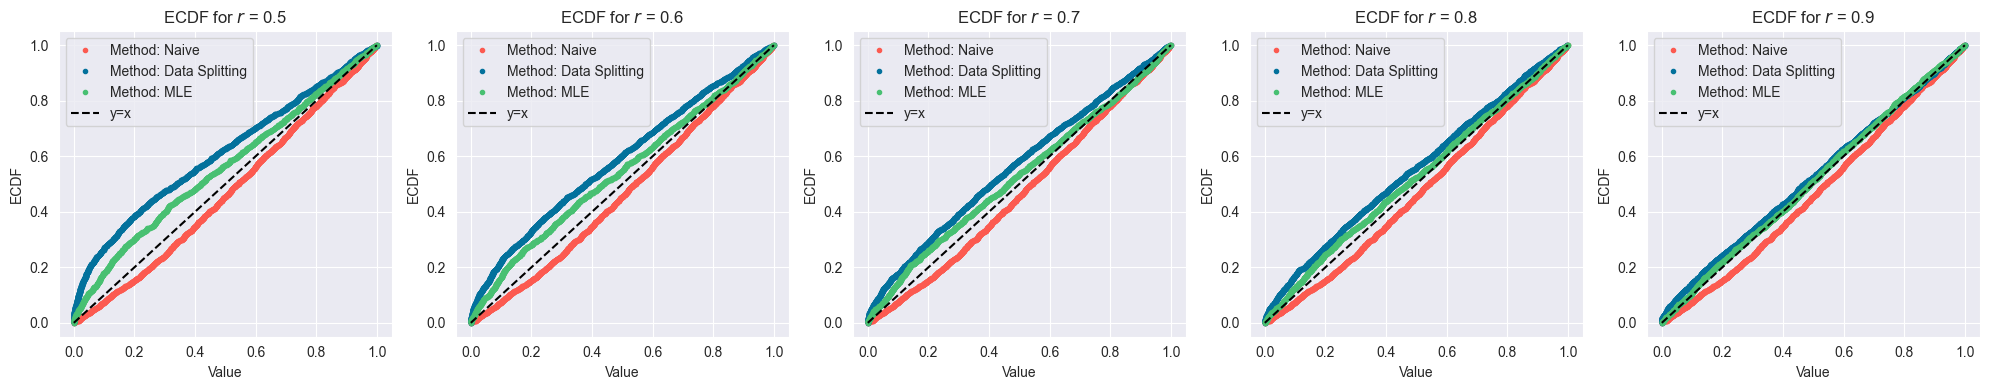

In [14]:
plot_ecdfs(pval_dict, xaxis="$r$")

In [15]:
## Plotting dict: SNR - Method - List of pvals
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                     operator=ge)

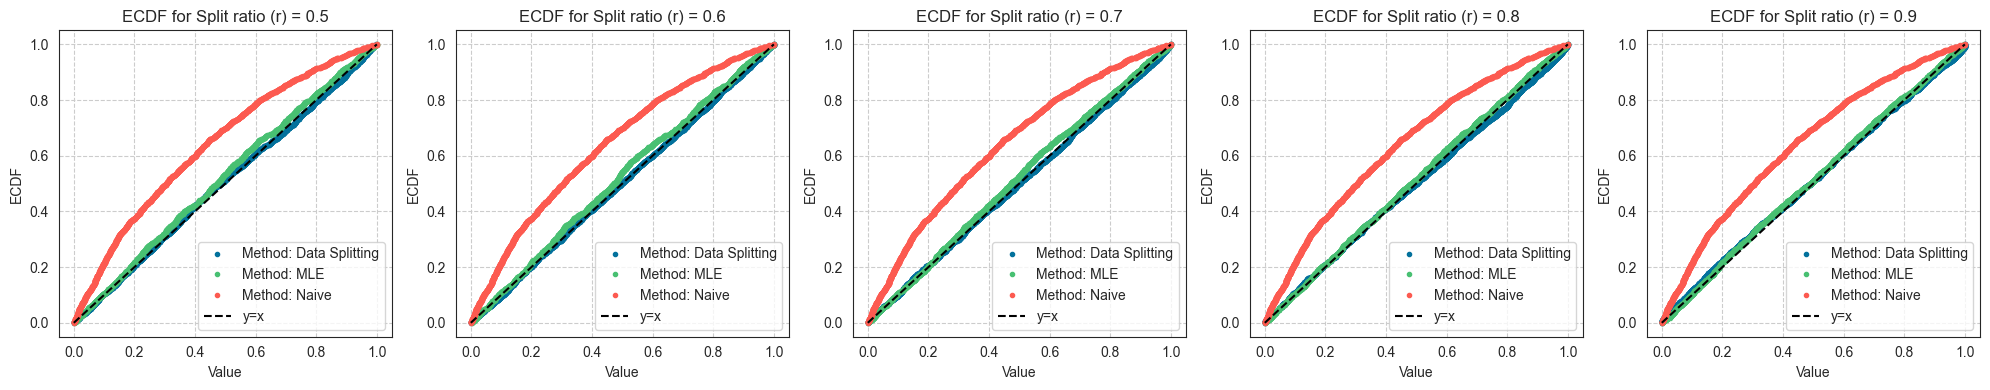

In [35]:
plot_ecdfs(filtered_dict, xaxis="Split ratio (r)")

In [17]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Average Length')

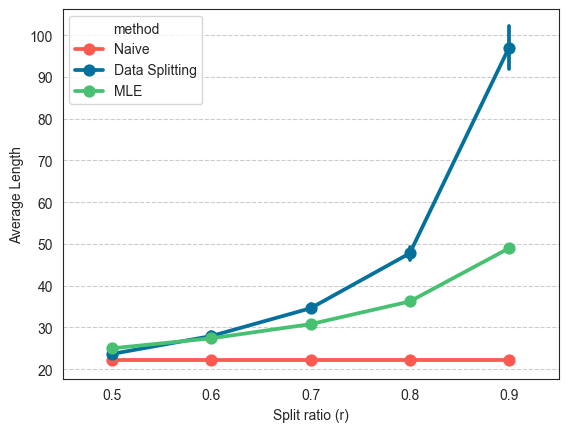

In [18]:
sns.pointplot(x=pd.DataFrame(oper_char)["prop"],
              y=pd.DataFrame(oper_char)["avg length"],
              hue=pd.DataFrame(oper_char)["method"], markers='o',
              palette=my_palette)
plt.xlabel("Split ratio (r)")
plt.ylabel("Average Length")

Text(0, 0.5, 'Test MSE')

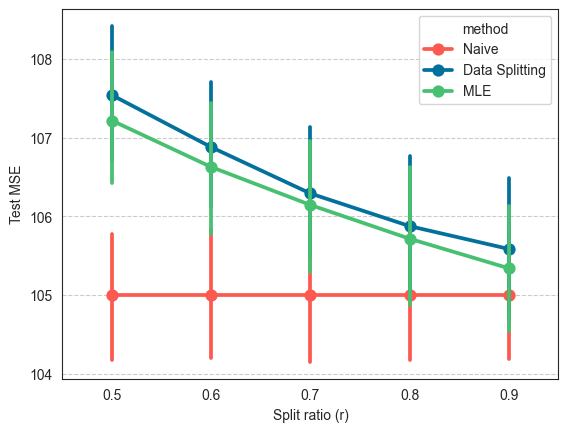

In [19]:
sns.pointplot(x=pd.DataFrame(MSE_dict)["prop"],
              y=pd.DataFrame(MSE_dict)["MSE"],
              hue=pd.DataFrame(MSE_dict)["method"], markers='o',
              palette=my_palette)
plt.xlabel("Split ratio (r)")
plt.ylabel("Test MSE")

In [20]:
# Applying BY Correction to the p-values

In [21]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [23]:
add_BY_pval_by_method_and_index(target_dict)

# Calculating Thresholded Power

In [25]:
def calculate_thresholded_power(pvalue, targets, level, threshold=0.05,
                                operator=ge):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = operator(np.abs(targets), threshold)
    rejection = pvalue < level
    if np.sum(non_null) == 0:
        return 0
    else:
        true_rej = np.sum(non_null * rejection) / np.sum(non_null)

    return true_rej

def calculate_thresholded_power_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   operator=ge, 
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['thresholded power'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['thresholded power'].append(
            calculate_thresholded_power(pvalues, targets, level=level, 
                                        threshold=threshold, operator=operator))
    return power_df

In [26]:
def point_plot_power(oper_char_dfs, x_axis='p', hue='method', 
                     ylim_low=None, ylim_high=None, exclude_naive=True,
                     randomizer_scales=None, x_label=None):
    for i in range(len(oper_char_dfs)):
        oper_char_dfs[i] = oper_char_dfs[i].copy()
        if exclude_naive:
            oper_char_dfs[i] = oper_char_dfs[i][oper_char_dfs[i]['method'] != "Naive"]
    sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()
    n_subplots = len(oper_char_dfs)
    # cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots

    fig = plt.figure(figsize=(cols * 5, 6))

    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i)  # one row
        if hue is not None:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          hue=oper_char_dfs[i-1][hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
            ax.set_title("Randomizer Scale:" + str(randomizer_scales[i-1]))
        else:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if ylim_low is not None and ylim_high is not None:
            ax.set_ylim([ylim_low, ylim_high])

        ax.legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)

    fig.subplots_adjust(bottom=0.3)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    # cov_plot.legend_.remove()
    # len_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    if x_label is not None:
        plt.xlabel(x_label)
    plt.show()

In [31]:
power_threshold = 1
power_df1 = calculate_thresholded_power_df(targets_dict=target_dict, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="BYpvals")

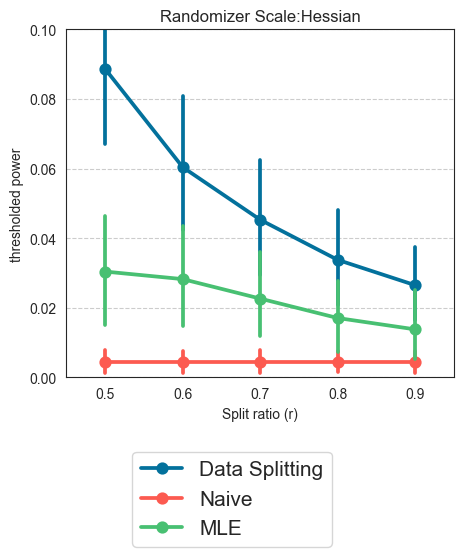

In [32]:
point_plot_power(oper_char_dfs=[pd.DataFrame(power_df1)],
                 x_axis="parameter",
                 hue="method", ylim_high=0.1, ylim_low=0,
                 randomizer_scales=["Hessian"], exclude_naive=False,
                 x_label="Split ratio (r)")

In [33]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

Text(0, 0.5, 'Thresholded Power')

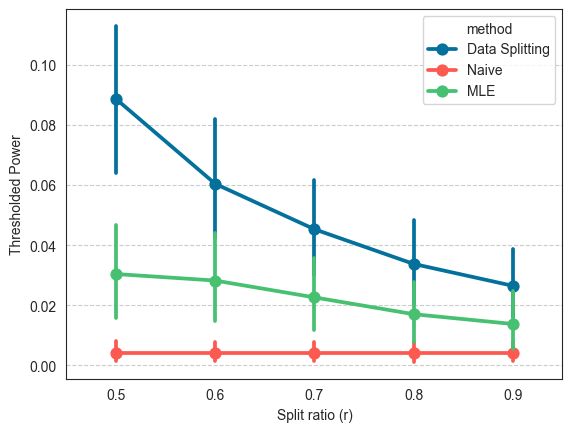

In [34]:
df = pd.DataFrame(power_df1)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Split ratio (r)")
plt.ylabel("Thresholded Power")